# Zadanie 1. Krzywe walidacji krzyżowej i optymalizacja parametrów
Wyniki treningu otrzymywane przy podziale train/valid/test bywają niestabilne i zależne od stanu generatora losowości, zwłaszcza przy małych danych. Rozwiązaniem jest walidacja krzyżowa. Dokończ przykład poniżej, tak by zoptymalizować model  <KNeighborsRegressor> dla zakresu parametru n_neighbors':range(1,60). Pokaż wyniki przy pomocy nowych wizualizacji w scikit-learn v1.3.


In [6]:
import sklearn
import sklearn.datasets


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


# some data
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)


# composite/pipeline model
full_model = Pipeline([('preprocess',StandardScaler()),('predictor',KNeighborsRegressor())])
param_grid = {'predictor__n_neighbors':range(1,60)} # search for how to name parameters in Pipelines -> using __


# grid-search using scikit-learn API
grid_search = GridSearchCV(
   full_model,
   cv=10,
   n_jobs=1,
   param_grid=param_grid,
   scoring="neg_root_mean_squared_error",  # turn RMSE loss into scoring (higher=better) -> negative RMSE
   return_train_score=True,
)


results = grid_search.fit(X, y)

In [2]:
#%pip install --upgrade scikit-learn>=1.3

In [4]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


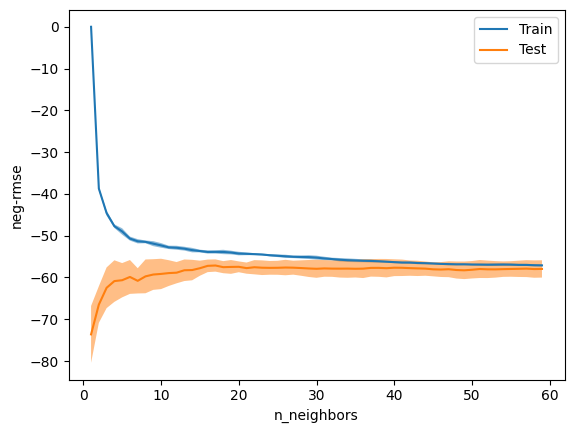

In [7]:
from sklearn.model_selection import ValidationCurveDisplay
import matplotlib.pyplot as plt
import numpy as np


# extract scores for all folds from <cv_results_> attribute, to use them in ValidationCurveDisplay
all_test_scores = np.column_stack((results.cv_results_['split0_test_score'],
                                  results.cv_results_['split1_test_score'],
                                  results.cv_results_['split2_test_score'],
                                  results.cv_results_['split3_test_score'],
                                  results.cv_results_['split4_test_score']))

all_train_scores = np.column_stack((results.cv_results_['split0_train_score'],
                                  results.cv_results_['split1_train_score'],
                                  results.cv_results_['split2_train_score'],
                                  results.cv_results_['split3_train_score'],
                                  results.cv_results_['split4_train_score']))


# plot validation curves along with standard errors
display = ValidationCurveDisplay(
   param_name='n_neighbors',
   param_range=range(1,60),
   train_scores=all_train_scores,
   test_scores=all_test_scores,
   score_name='neg-rmse'
)
display.plot(std_display_style='fill_between')
plt.show()


# Zadanie 3. Ocena klasyfikacji binarnej
Na potrzeby klasyfikacji binarnej budujemy najczęściej modele szacujące prawdopodobieństwo wystąpienia efektu (choroby / przeżycia / przestępstwa…) w skali ciągłej od 0 do 100%. Takie modele dają możliwość elastycznej decyzji w zależności od progu. Dla modelu poniżej znajdź próg decyzji przy którym suma częstości błędów pierwszego i drugiego typu (FPR+FNR) jest najmniejsza (można posłużyć się wizualizacją macierzy pomyłek).


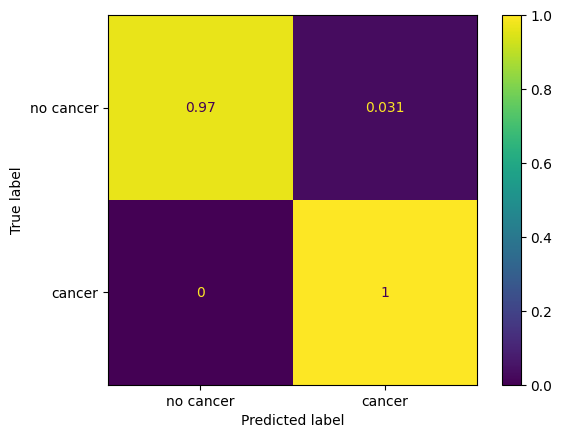

In [28]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


X,y = sklearn.datasets.load_breast_cancer(return_X_y=True)


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=41)


full_model = Pipeline(
   [('preprocess',StandardScaler()),
    ('predictor',LogisticRegression())]
)


model = full_model.fit(X_train,y_train)
y_score = model.predict_proba(X_train)[:,1] # risk/continous (!) predictions


t_decision = 0.43 # try to optimize the decision threshold to achieve the lowest Type I + Type II error
conf_matrix = confusion_matrix(y_train,y_score>=t_decision,normalize='true')
ConfusionMatrixDisplay(conf_matrix,display_labels=['no cancer','cancer']).plot()


In [27]:
err = []
for t in np.arange(0.01, 1, 0.01):
  conf_matrix = confusion_matrix(y_train,y_score>=t,normalize='true')
  err.append(conf_matrix[0, 1] + conf_matrix[1, 0])

err = np.array(err)
print("Optimal t:", (err.argmin()+1)/100)

Optimal t: 0.43


# Zadanie 6 z notebook'a

In [49]:
diabetes = sklearn.datasets.load_diabetes()
xtrain, xtest, ytrain, ytest = train_test_split(diabetes.data, diabetes.target, test_size=0.2)
xptrain, xval, yptrain, yval = train_test_split(xtrain, ytrain)

**Exercise 6 -- KNN regression\*\*** We may combine regression with k-nearest neighbors. Note that such a model may be valuable for predictions but will not be readily interpretable.

In KNN regression, the target is predicted by locally interpolating the targets associated with the nearest neighbors in the training set.

**Exercise 6a\*\*** Use the split of the data from Exercise 5. Create, fit, and evaluate with RMSE a K-nn regressor on the diabetes data (assume $k=3$). See documentation for [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) for syntax details.

In [50]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

neigh = KNeighborsRegressor(n_neighbors=3)
results = neigh.fit(xtrain, ytrain)

ypred = results.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, ypred))

rmse

56.84953968412698

**Exercise 6b\*\*** Regression, as classification is supervised learning; thus, any hyperparameters can be tuned (using validation data) similarly. Tune the $k$ hyperparameter of the K-nn regression model. Make a plot of RMSE as the function of $k$ and identify the most promising value of $k$.

Optimal k: 14 , Min RMSE:  56.03985250394731


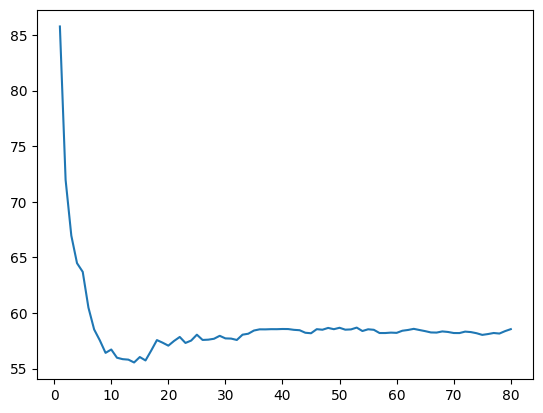

In [51]:
import matplotlib.pyplot as plt

rmse = []
k_range = range(1, 81)
for k in k_range:
  neigh = KNeighborsRegressor(n_neighbors=k)
  results = neigh.fit(xptrain, yptrain)
  ypred = results.predict(xval)
  rmse.append(np.sqrt(mean_squared_error(ypred, yval)))

rmse = np.array(rmse)
k_opt = rmse.argmin() + 1
print("Optimal k:", k_opt, ", Min RMSE: ", rmse[k_opt])
plt.plot(k_range, rmse)
plt.show()

**Exercise 6c\*\*** Preprocessing the data, e.g., by normalizing it, may improve the performance of the regressor. On a single plot, make a graph of the dependence of RMSE as the function of $k$ (ranging from 1 to 80) for two variants:
1. not-normalized data (red)
1. data normalized with `StandardScaler` (green)

Can you see the improvement in the performance? Tou can try it with various random data splits.

Optimal k:  13 , Min RMSE:  55.76976751417552


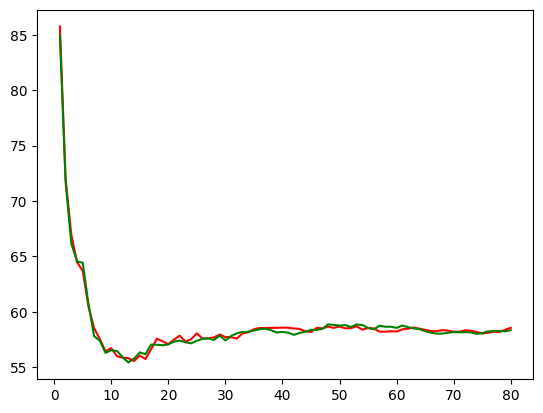

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rmse = []
rmse_scaled = []
k_range = range(1, 81)
for k in k_range:
  neigh = KNeighborsRegressor(n_neighbors=k)
  results = neigh.fit(xptrain, yptrain)
  ypred = results.predict(xval)
  rmse.append(np.sqrt(mean_squared_error(ypred, yval)))

  pipe = Pipeline([('preprocess', StandardScaler()), ('predictor', KNeighborsRegressor(n_neighbors = k))])
  pipe.fit(xptrain, yptrain)
  ypred = pipe.predict(xval)
  rmse_scaled.append(np.sqrt(mean_squared_error(ypred, yval)))

rmse = np.array(rmse)
rmse_scaled = np.array(rmse_scaled)

k_opt = rmse_scaled.argmin() + 1
print("Optimal k: ", k_opt, ", Min RMSE: ", rmse_scaled[k_opt])
plt.plot(k_range, rmse, color='red')
plt.plot(k_range, rmse_scaled, color='green')

plt.show()

**Exercise 6d\*\***  Finally, identify the optimum value of k, train the final model on the re-merged partial train (xptrain) and validation (xval) dataset, and print the final model's RMSE on the test data. Compare the results against the models from the previous Exercises.

In [54]:
k_opt = 13
neigh = KNeighborsRegressor(n_neighbors=k_opt)
results = neigh.fit(xtrain, ytrain)
ypred = results.predict(xtest)
rmse = np.sqrt(mean_squared_error(ypred, ytest))
print("RMSE achieved by the optimal model on the test data: ", rmse)

RMSE achieved by the optimal model on the test data:  50.14891593076877
